In [1]:
# Import libraries and set desired options
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

**Read training and test sets, sort train set by session start time.**

In [3]:
train_df = pd.read_csv('../input/train_sessions.csv',
                       index_col='session_id', parse_dates=['time1'])
test_df = pd.read_csv('../input/test_sessions.csv',
                      index_col='session_id', parse_dates=['time1'])

# Sort the data by time
train_df = train_df.sort_values(by='time1')

times = ['time%s' % i for i in range(1, 11)]
train_df.fillna(0)
test_df.fillna(0)

train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)


# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


**Transform data into format which can be fed into `CountVectorizer`**

In [4]:
time_df = pd.DataFrame(index=train_df.index)

time_df['min'] = train_df[times].min(axis=1) 
time_df['max'] = train_df[times].max(axis=1)
time_df['minutes'] = round(((time_df['max'] - time_df['min']) / np.timedelta64(1, 's'))/60, 2).astype(np.int8)
time_df['target'] = train_df['target']

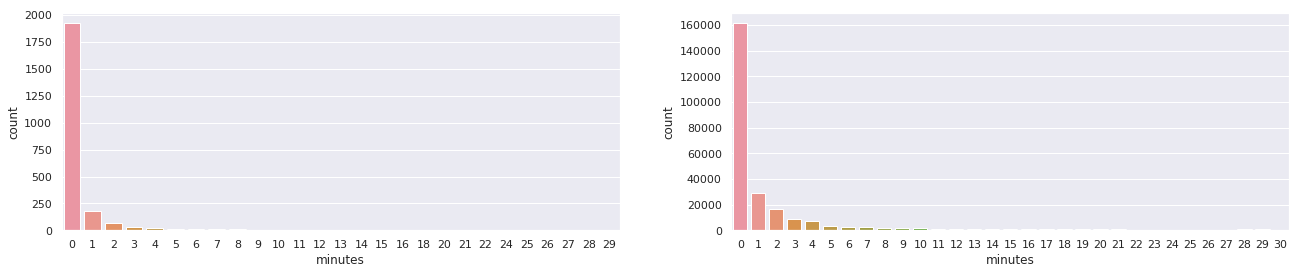

In [5]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,4))
idx = time_df.shape[0]
sns.countplot(x="minutes", data=time_df[time_df.target==1][:idx], ax=axes[0]) # Alice
sns.countplot(x="minutes", data=time_df[time_df.target==0][:idx], ax=axes[1]) # Not Alice

In [6]:
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites].fillna(0).astype('int').to_csv('train_sessions_text.txt', 
                                               sep=' ', 
                       index=None, header=None)
test_df[sites].fillna(0).astype('int').to_csv('test_sessions_text.txt', 
                                              sep=' ', 
                       index=None, header=None)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [7]:
!head -5 train_sessions_text.txt

56 55 0 0 0 0 0 0 0 0
56 55 56 55 0 0 0 0 0 0
946 946 951 946 946 945 948 784 949 946
945 948 949 948 945 946 947 945 946 946
947 950 948 947 950 952 946 951 946 947


**Fit `CountVectorizer` and transfrom data with it.**

In [8]:
%%time
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)
X_train.shape, X_test.shape

CPU times: user 12.6 s, sys: 376 ms, total: 13 s
Wall time: 13 s


((253561, 50000), (82797, 50000))

**Save train targets into a separate vector.**

In [9]:
y_train = train_df['target'].astype('int').values

**We'll be performing time series cross-validation, see `sklearn` [TimeSeriesSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) and [this dicussion](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection) on StackOverflow.**

In [10]:
time_split = TimeSeriesSplit(n_splits=10)

<img src="https://habrastorage.org/webt/8i/5k/vx/8i5kvxrehatyvf-l3glz_-ymhtw.png" />

In [11]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_train)]

[((23051,), (23051,)),
 ((46102,), (23051,)),
 ((69153,), (23051,)),
 ((92204,), (23051,)),
 ((115255,), (23051,)),
 ((138306,), (23051,)),
 ((161357,), (23051,)),
 ((184408,), (23051,)),
 ((207459,), (23051,)),
 ((230510,), (23051,))]

**Perform time series cross-validation with logistic regression.**

In [12]:
logit = LogisticRegression(C=1, random_state=17, solver='liblinear')

In [13]:
%%time

cv_scores = cross_val_score(logit, X_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=1) # hangs with n_jobs > 1, and locally this runs much faster

CPU times: user 53.7 s, sys: 220 ms, total: 53.9 s
Wall time: 53.9 s


In [14]:
cv_scores, cv_scores.mean()

(array([0.83141992, 0.64669477, 0.87991957, 0.9631551 , 0.84221742,
        0.87840596, 0.94476054, 0.85321751, 0.92987618, 0.90752852]),
 0.8677195468747974)

**Train logistic regression with all training data, make predictions for test set and form a submission file.**

In [15]:
logit.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
logit_test_pred = logit.predict_proba(X_test)[:, 1]
write_to_submission_file(logit_test_pred, 'subm1.csv') # 0.91288

**Now we'll add some time features: indicators of morning, day, evening and night.**

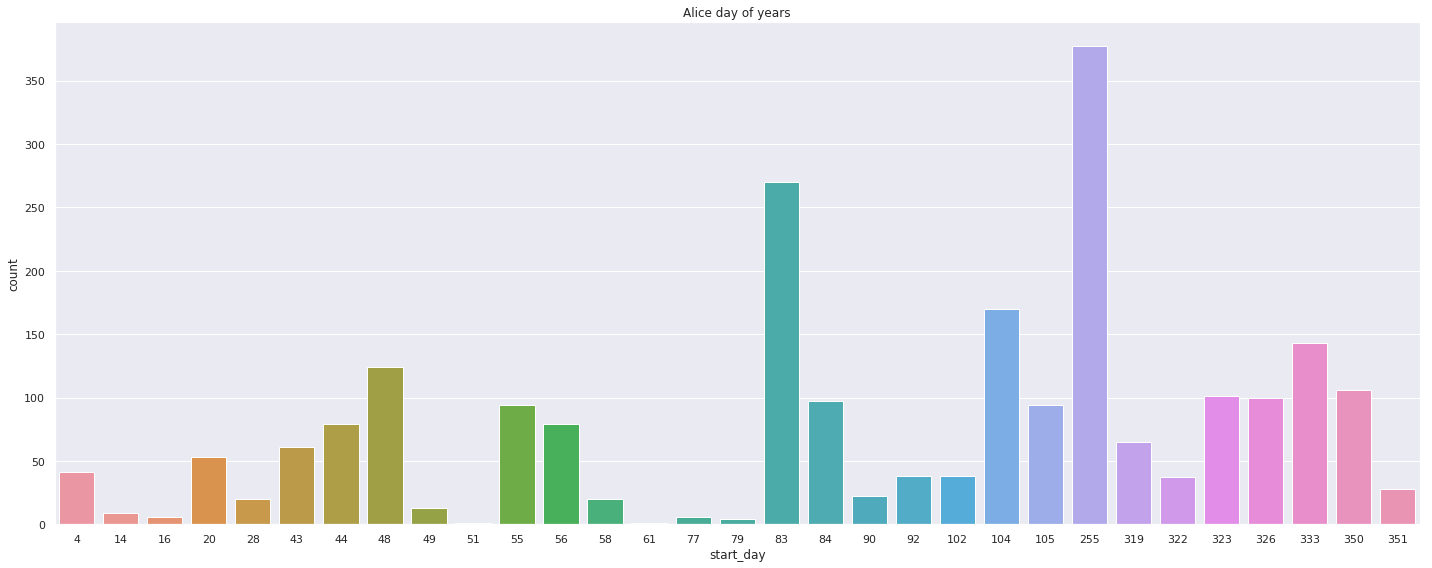

In [17]:
train_df['start_day'] = train_df['time1'].apply(lambda ts: ts.timetuple().tm_yday)
plt.figure(figsize=(20, 8))

plt.title('Alice day of years')
sns.countplot(x="start_day", data=train_df[train_df['target']==1])
plt.tight_layout()

#train_df["start_day"].value_counts()
#train_df[train_df['target'] == 1].groupby('start_day').agg('count')

ValueError: Could not interpret input 'dayofweek'

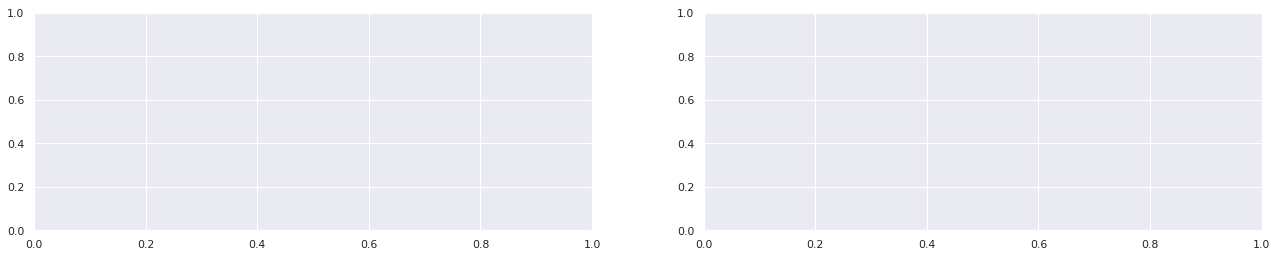

In [18]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,4))
idx = train_df.shape[0]
sns.countplot(x="dayofweek", data=train_df[train_df.target==1][:idx], ax=axes[0]) # Alice
sns.countplot(x="dayofweek", data=train_df[train_df.target==0][:idx], ax=axes[1]) # Not Alice

ValueError: Could not interpret input 'mm'

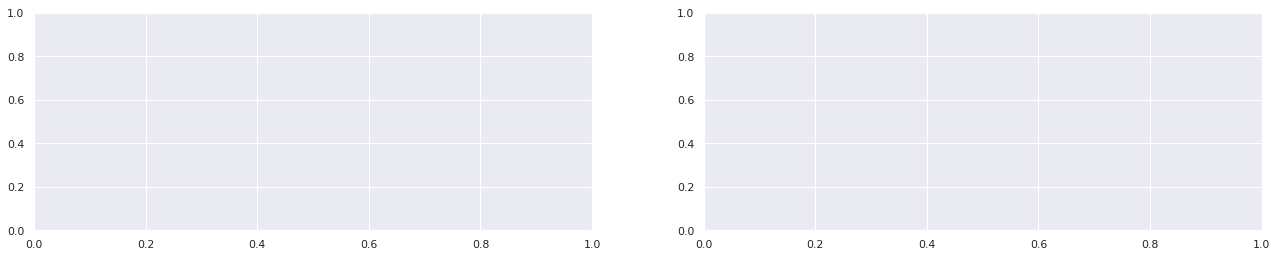

In [19]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,4))
idx = train_df.shape[0]
sns.countplot(x="mm", data=train_df[train_df.target==1][:idx], ax=axes[0]) # Alice
sns.countplot(x="mm", data=train_df[train_df.target==0][:idx], ax=axes[1]) # Not Alice

In [20]:
hosts = pd.read_pickle('../input/site_dic.pkl')
hosts = pd.DataFrame(data=list(hosts.keys()), index=list(hosts.values()), columns=['name']) # switch key and value
#hosts = hosts.iloc[:48371]
#253561
hosts['split'] = hosts['name'].str.split('.')
hosts['len'] = hosts['split'].map(lambda x: len(x)).astype(np.int8)
hosts['domain'] = hosts['split'].map(lambda x: x[-1])


hosts.drop(['name','split'], inplace=True, axis=1)
hosts.index.rename('site1', inplace=True) # rename index for the future merge
train_df = pd.merge(train_df, hosts, how='left', on='site1')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


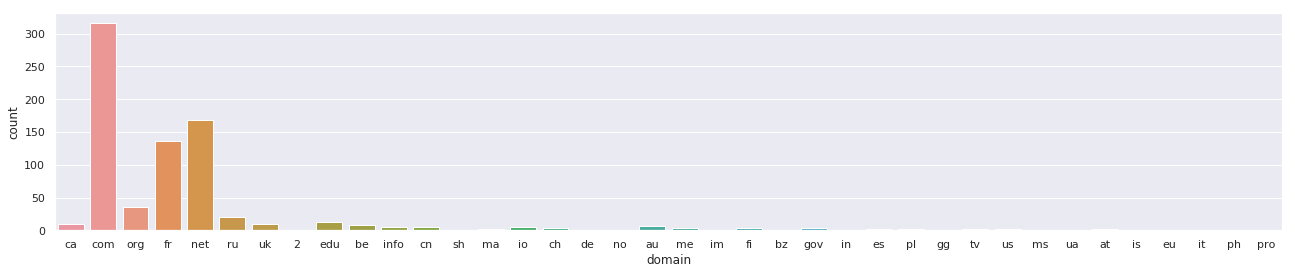

In [21]:
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,4))
idx = train_df.shape[0]
sns.countplot(x="domain", data=hosts[train_df.target==1][:idx], ax=axes) # Alice
#sns.countplot(x="domain", data=train_df[train_df.target==0][:idx], ax=axes[1]) # Not Alice
#train_df.head()

In [22]:
def add_time_features(df, X_sparse):
    # Create a separate dataframe where we will work with timestamps
    time_df = pd.DataFrame(index=df.index)

    time_df['min'] = df[times].min(axis=1) 
    time_df['max'] = df[times].max(axis=1)
    time_df['minutes'] = round(((time_df['max'] - time_df['min']) / np.timedelta64(1, 's'))/60, 2)
    
    start_day = time_df['min'].apply(lambda ts: 1 if ts.timetuple().tm_yday in {104, 333, 48, 350, 323, 326, 84, 55, 105, 44, 56, 319, 43, 20, 322, 351, 4, 92, 102, 90, 28, 58} else 0)
    #year_month = df['time1'].apply(lambda ts: 100 * ts.year + ts.month).astype(np.int32)
    online_day = time_df['min'].apply(lambda ts: 1 if ts.dayofweek in [0, 1, 3, 4] else 0)
    month = time_df['min'].apply(lambda ts: 1 if ts.month in [2, 3, 4, 9, 11] else 0)
    hour = time_df['min'].apply(lambda ts: 1 if ts.hour in [12, 13, 16, 17, 18] else 0)
    #morning = ((hour >= 7) & (hour <= 11)).astype('int')
    #day = ((hour >= 12) & (hour <= 18)).astype('int')
    #evening = ((hour >= 19) & (hour <= 23)).astype('int')
    #weekday = time_df['min'].apply(lambda ts: 1 if ts.date().weekday() in (5, 6) else 0)
    intruder_hours = time_df['min'].apply(lambda ts: 1 if (ts.date().weekday() in (0, 1, 2, 3, 4)) &
                                             ((ts.hour>=8)&(ts.hour<=17)) else 0)
    #minutes = time_df['minutes'].astype('int')
    #night = ((hour >= 0) & (hour <= 6)).astype('int')
    #X = hstack([X_sparse, morning.values.reshape(-1, 1), 
                #day.values.reshape(-1, 1), evening.values.reshape(-1, 1), 
                #night.values.reshape(-1, 1)])
    X = hstack([X_sparse, start_day.values.reshape(-1, 1), #minutes.values.reshape(-1, 1),#morning.values.reshape(-1, 1), night.values.reshape(-1, 1),
                intruder_hours.values.reshape(-1, 1), #day.values.reshape(-1, 1), evening.values.reshape(-1, 1), 
                online_day.values.reshape(-1, 1), month.values.reshape(-1, 1), hour.values.reshape(-1, 1)])
    return X

In [23]:
%%time
#X_train_new = add_time_features(train_df.fillna(0), X_train)
#X_test_new = add_time_features(test_df.fillna(0), X_test)
X_train_new = add_time_features(train_df, X_train)
X_test_new = add_time_features(test_df, X_test)

CPU times: user 9.08 s, sys: 76 ms, total: 9.16 s
Wall time: 9.15 s


In [24]:
X_train_new.shape, X_test_new.shape

((253561, 50005), (82797, 50005))

**Performing time series cross-validation, we see an improvement in ROC AUC.**

In [25]:
%%time
cv_scores = cross_val_score(logit, X_train_new, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=1) # hangs with n_jobs > 1, and locally this runs much faster

CPU times: user 45.3 s, sys: 236 ms, total: 45.5 s
Wall time: 45.5 s


In [26]:
cv_scores, cv_scores.mean()

(array([0.88475192, 0.86108882, 0.93963397, 0.98503973, 0.97081113,
        0.97553257, 0.94683406, 0.95633994, 0.95598713, 0.97759904]),
 0.9453618302423406)

**Making a new submission, we notice a leaderboard score improvement as well (0.91288 ->  0.93843). Correlated CV and LB improvements is a good justifications for added features being useful and CV scheme being correct.**

In [27]:
logit.fit(X_train_new, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
logit_test_pred2 = logit.predict_proba(X_test_new)[:, 1]
write_to_submission_file(logit_test_pred2, 'subm2.csv') # 0.93843

**Now we tune regularization parameter `C`.**

In [29]:
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [30]:
%%time
logit_grid_searcher.fit(X_train_new, y_train) # WTF? Locally, it's 3min 30s

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.4min finished


CPU times: user 11.6 s, sys: 240 ms, total: 11.8 s
Wall time: 8min 34s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=

In [31]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9464686144021088, {'C': 0.5994842503189409})

In [32]:
logit_test_pred3 = logit_grid_searcher.predict_proba(X_test_new)[:, 1]
write_to_submission_file(logit_test_pred3, 'subm3.csv') # 0.94242

**Again, we notice an improvement in both cross-validation score and LB score. Now that you've settled a correct cross-validation scheme, go on with feature engineering! Good luck!**